<a href="https://colab.research.google.com/github/ghl051/ghl051/blob/main/Practice_Project_Data_Analytics_for_Insurance_Cost_Data_Set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split

In [5]:
!pip install seaborn


In [8]:
import requests

def download(url, filename):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as f:
            f.write(response.content)

filepath = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/medical_insurance_dataset.csv'
download(filepath, "insurance.csv")
file_name = "insurance.csv"


In [9]:
df = pd.read_csv(file_name)

In [11]:
df.head()

,19,1,27.9,0,1.1,3,16884.924
0,18,2,33.770,1,0,4,1725.55230
1,28,2,33.000,3,0,4,4449.46200
2,33,2,22.705,0,0,1,21984.47061
3,32,2,28.880,0,0,1,3866.85520
4,31,1,25.740,0,?,4,3756.62160


In [12]:
# Add the headers to the dataframe, as mentioned in the project scenario.
headers = ["age", "gender", "bmi", "no_of_children", "smoker", "region", "charges"]
df.columns = headers

In [13]:
# replace the '?' entries with 'NaN' values.
df.replace('?', np.nan, inplace = True)

# Data Wrangling

In [14]:
# Use dataframe.info() to identify the columns that have some 'Null' (or NaN) information.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2767 non-null   object 
 1   gender          2771 non-null   int64  
 2   bmi             2771 non-null   float64
 3   no_of_children  2771 non-null   int64  
 4   smoker          2764 non-null   object 
 5   region          2771 non-null   int64  
 6   charges         2771 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 151.7+ KB
None


Handle missing data:

For continuous attributes (e.g., age), replace missing values with the mean.
For categorical attributes (e.g., smoker), replace missing values with the most frequent value.
Update the data types of the respective columns.
Verify the update using df.info().

In [15]:
# smoker is a categorical attribute, replace with most frequent entry
is_smoker = df['smoker'].value_counts().idxmax()
df["smoker"].replace(np.nan, is_smoker, inplace=True)

# age is a continuous variable, replace with mean age
mean_age = df['age'].astype('float').mean(axis=0)
df["age"].replace(np.nan, mean_age, inplace=True)

# Update data types
df[["age","smoker"]] = df[["age","smoker"]].astype("int")

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2771 non-null   int64  
 1   gender          2771 non-null   int64  
 2   bmi             2771 non-null   float64
 3   no_of_children  2771 non-null   int64  
 4   smoker          2771 non-null   int64  
 5   region          2771 non-null   int64  
 6   charges         2771 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 151.7 KB
None


In [16]:
# Also note, that the charges column has values which are more than 2 decimal places long. Update the charges column such that all values are rounded to nearest 2 decimal places. Verify conversion by printing the first 5 values of the updated datafr
df[["charges"]] = np.round(df[["charges"]],2)
print(df.head())

   age  gender     bmi  no_of_children  smoker  region   charges
0   18       2  33.770               1       0       4   1725.55
1   28       2  33.000               3       0       4   4449.46
2   33       2  22.705               0       0       1  21984.47
3   32       2  28.880               0       0       1   3866.86
4   31       1  25.740               0       0       4   3756.62


# Exploratory Data Analysis (EDA)

(0.0, 66902.85800000001)

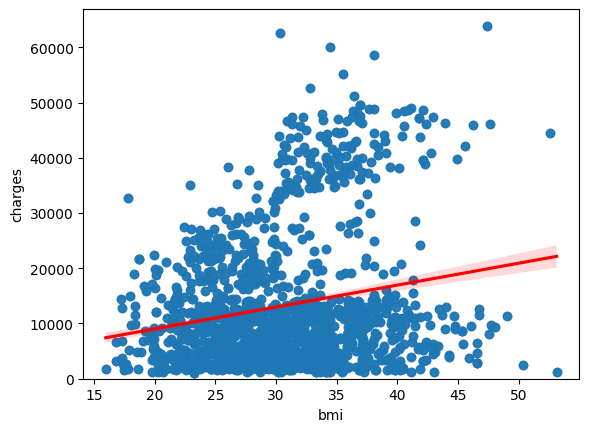

In [17]:
# Implement the regression plot for charges with respect to bmi.
sns.regplot(x="bmi", y="charges", data=df, line_kws={"color": "red"})
plt.ylim(0,)

<Axes: xlabel='smoker', ylabel='charges'>

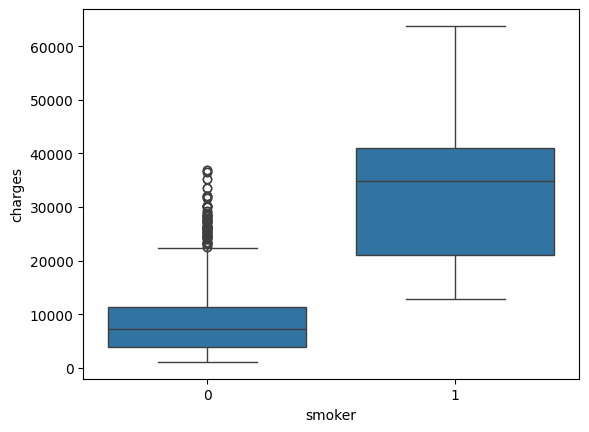

In [18]:
# Implement the box plot for charges with respect to smoker.
sns.boxplot(x="smoker", y="charges", data=df)

In [19]:
# Print the correlation matrix for the dataset.
print(df.corr())

                     age    gender       bmi  no_of_children    smoker  \
age             1.000000 -0.026584  0.112859        0.037126 -0.022290   
gender         -0.026584  1.000000  0.042766        0.015693  0.083125   
bmi             0.112859  0.042766  1.000000       -0.001642  0.011824   
no_of_children  0.037126  0.015693 -0.001642        1.000000  0.007016   
smoker         -0.022290  0.083125  0.011824        0.007016  1.000000   
region         -0.006969  0.022360  0.271200       -0.025594  0.053839   
charges         0.298892  0.062959  0.199906        0.066551  0.789141   

                  region   charges  
age            -0.006969  0.298892  
gender          0.022360  0.062959  
bmi             0.271200  0.199906  
no_of_children -0.025594  0.066551  
smoker          0.053839  0.789141  
region          1.000000  0.054018  
charges         0.054018  1.000000  


# Model Development

In [20]:
# Fit a linear regression model that may be used to predict the `charges` value, just by using the `smoker` attribute of the dataset. Print the $ R^2 $ score of this model.
X = df[['smoker']]
Y = df['charges']
lm = LinearRegression()
lm.fit(X,Y)
print(lm.score(X, Y))

0.6227430402464125


In [21]:
# definition of Y and lm remain same as used in last cell.
Z = df[["age", "gender", "bmi", "no_of_children", "smoker", "region"]]
lm.fit(Z,Y)
print(lm.score(Z, Y))

0.7505888664568174


In [22]:
# Create a training pipeline that uses `StandardScaler()`, `PolynomialFeatures()` and `LinearRegression()` to create a model that can predict the `charges` value using all the other attributes of the dataset. There should be even further improvement in the performance.
# Y and Z use the same values as defined in previous cells
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False)), ('model', LinearRegression())]
pipe=Pipeline(Input)
Z = Z.astype(float)
pipe.fit(Z,Y)
ypipe=pipe.predict(Z)
print(r2_score(Y,ypipe))


0.8453619005168813


# Model Refinement
Split the data into training and testing subsets, assuming that 20% of the data will be reserved for testing.

In [23]:
# Z and Y hold same values as in previous cells
x_train, x_test, y_train, y_test = train_test_split(Z, Y, test_size=0.2, random_state=1)

In [24]:
#Initialize a Ridge regressor that used hyperparameter $ \alpha = 0.1 $. Fit the model using training data data subset. Print the $ R^2 $ score for the testing data.
# x_train, x_test, y_train, y_test hold same values as in previous cells
RidgeModel=Ridge(alpha=0.1)
RidgeModel.fit(x_train, y_train)
yhat = RidgeModel.predict(x_test)
print(r2_score(y_test,yhat))

0.7254198858412229


Apply polynomial transformation to the training parameters with degree=2. Use this transformed feature set to fit the same regression model, as above, using the training subset. Print the $ R^2 $ score for the testing subset.


In [25]:
# x_train, x_test, y_train, y_test hold same values as in previous cells
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)
RidgeModel.fit(x_train_pr, y_train)
y_hat = RidgeModel.predict(x_test_pr)
print(r2_score(y_test,y_hat))

0.8208413195172477
